In [93]:
import re
from os import path
import numpy as np
import pandas as pd
import zipfile
import nltk
import sys
# import wget
import time
from sklearn.model_selection import train_test_split
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import keras
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras import optimizers
from keras.layers import SimpleRNN,Dense,LSTM,Dropout,GRU,Bidirectional
from keras import regularizers


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [94]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
np.set_printoptions(threshold=sys.maxsize)
pd.options.mode.chained_assignment = None

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


In [95]:
# Only include classes specified in accepted_class 
def clean_class(df,accepted_class:np.ndarray):
   # accepted_class = np.array([1, 0, -1])
    decode_map = {0: 0, 2: 2, 1: 1,-1:-1, '0': 0, '2': 2, '1': 1,'-1':-1}
    df['target'].map(decode_map)
    df = df.loc[df['target'].isin(accepted_class)]
    df.astype({'target': 'int'}).dtypes
    return df

In [96]:
def preprocess_text(text):
    wordnet_lemmatizer = WordNetLemmatizer()
    text = text.lower()
    # removing tags and text inside tags Eg: <a> , <e>
    text = re.sub('<[^>]*>','',text)
    # removing Http Links
    text = re.sub('https?:\S+','',text)
    # removing special characters
    text = re.sub('[^\w\s]','',text)
   # text = re.sub('[0-9]+','',text)
    text = ' '.join(word for word in text.split() if word not in stopwords.words('english')) 
    text = ' '.join(wordnet_lemmatizer.lemmatize(word) for word in text.split())
    return text.strip()

In [97]:
%%time
def load_glove_embeddings():
#     if not path.exists('glove.twitter.27B.zip'):
#         print('Please wait while the Global Vector Word Embeddings are being downloaded.')
#         !wget 'http://nlp.stanford.edu/data/glove.twitter.27B.zip'
#         #unzip glove*.zip
#     glove = zipfile.ZipFile('glove.twitter.27B.zip')
    embeddings = {}
    with open('../input/glovetwitter/glove.twitter.27B.200d.txt','r') as file:
        for line in file:
#             line = line.decode('utf-8')
            words = line.split()
            word = words[0]
            word_vectors = np.asarray(words[1:], dtype='float32')
            embeddings[word] = word_vectors
    return embeddings
word_embeddings = load_glove_embeddings()

CPU times: user 2min 3s, sys: 1.96 s, total: 2min 5s
Wall time: 2min 4s


In [98]:
def generate_embeddings():
    vocab_size = len(tokenizer.word_index)+1
    embedding_size = 200
    embedding_matrix = np.zeros((vocab_size, embedding_size))
    for word,index in tokenizer.word_index.items():
        vector = word_embeddings.get(word)
        if vector is not None:
            embedding_matrix[index] = vector
    return embedding_matrix

In [99]:
# def read_input():
#     if not path.exists('training-Obama-Romney-tweets.rar'):
#         print('Downloading training-Obama-Romney-tweets.rar')
#         wget.download('https://www.cs.uic.edu/~liub/teach/cs583-fall-20/training-Obama-Romney-tweets.rar')
#     rar = rarfile.RarFile('training-Obama-Romney-tweets.rar')
#     input =rar.open('training-Obama-Romney-tweets.xlsx')
#     return input

In [100]:
sheets = [0,1]
input_data = pd.read_excel('../input/cs583-dataset/training-Obama-Romney-tweets.xlsx',sheet_name=sheets)

In [101]:
def clean_excel(data:pd.DataFrame):
    # Preprocessing Training data
    # Removing first row as it has only information about class value mappings
    data = data[1:]
    data.rename(columns={'Unnamed: 4': 'target'}, inplace=True)
    # Dropping empty columns
    data.dropna(how='all', inplace=True, axis=1)
    #Dropping date and time
    data.dropna(subset=['Anootated tweet','target'] ,inplace=True, axis=0)
    return data

In [122]:
# Function to plot the Accuracy and Loss of the training and testing models

def generate_plot(model):
    plt.plot(model.history['accuracy'])
    plt.plot(model.history['val_accuracy'])
    plt.title('Model Accuracy (Train & Validation)')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()

    plt.plot(model.history['loss'])
    plt.plot(model.history['val_loss'])
    plt.title('Model Loss(Train & Validation)')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()


# Returns trained model and pred_labels for test data only if train_on_all_data=False 
def train_evaluate_model(**kwargs):
    
    data=kwargs['data']
    labels = kwargs['labels']
    model_type = kwargs['model_type']
    input_len = kwargs['input_length']
    model_units = kwargs['model_units']
    epochs = kwargs['epochs']
    learning_rate = kwargs['learning_rate']
    weight_matrix = kwargs['weights']
    train_on_all_data = kwargs['train_on_all_data']
    
    if(not train_on_all_data):
        #Splitting the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(data['Anootated tweet'],labels, test_size=0.2, stratify=data_clean['target'])
        X_train_processed = tokenizer.texts_to_sequences(X_train)
        X_train_processed = pad_sequences(X_train_processed, padding='post', maxlen=50,truncating='pre')
        X_test_processed = tokenizer.texts_to_sequences(X_test)
        X_test_processed = pad_sequences(X_test_processed, padding='post', maxlen=50,truncating='pre')
    else:
        X_train_processed = tokenizer.texts_to_sequences(X_train)
        X_train_processed = pad_sequences(X_train_processed, padding='post', maxlen=50,truncating='pre')
        y_train = labels
 
    model = Sequential()
    embedding_layer = Embedding(len(tokenizer.word_index) + 1, 200, weights=[weight_matrix], input_length=input_len,
                                trainable=False, mask_zero=True)
    model.add(embedding_layer)
    if kwargs['model_type'] == 'rnn':
        model.add(SimpleRNN(model_units,kernel_regularizer = regularizers.l1_l2(l1=0.01, l2=0.01)))
    elif kwargs['model_type'] == 'lstm':
        model.add(LSTM(units=model_units,kernel_regularizer = regularizers.l1_l2(l1=0.01, l2=0.01)))
    elif kwargs['model_type'] == 'gru':
        model.add(GRU(units=model_units,kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)))
    else:
        model.add(Bidirectional(LSTM(units=model_units,kernel_regularizer = regularizers.l1_l2(l1=0.01, l2=0.01))))
    
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='sigmoid'))
    opt = tf.keras.optimizers.Adam(learning_rate)
    model.compile(opt, loss='categorical_crossentropy', metrics=['accuracy'])
    print(model.summary())
    dot_img_file = 'model_1.png'
    tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)
    model_history = model.fit(X_train_processed, y_train, batch_size=128, epochs=epochs, verbose=1, validation_split=0.2)
    plot = generate_plot(model_history)
    if(not train_on_all_data):
        print("Test data eval")
        model.evaluate(X_test_processed, y_test)
        test_pred_labels = model.predict(X_test_processed)
       # test_pred_labels = pd.Series(test_pred).idxmax(axis=1)
        return model,test_pred_labels
    else :
        return model

In [103]:
data_clean = pd.DataFrame()
for i in sheets:
    data_temp = clean_excel(input_data[i])
    data_clean=data_clean.append(data_temp)
data_clean = clean_class(data_clean,np.array([1,0,-1]))

In [104]:
%%time
data_clean['Anootated tweet']=data_clean['Anootated tweet'].apply(lambda x: preprocess_text(x))

CPU times: user 26 s, sys: 2.44 s, total: 28.4 s
Wall time: 28.5 s


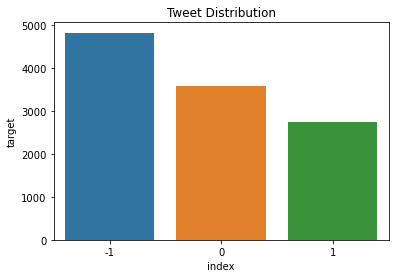

In [105]:
target_count = data_clean['target'].value_counts().reset_index()
ax = sns.barplot(x=target_count['index'], y=target_count['target'])
plt.title("Tweet Distribution")
plt.show()

In [106]:
#convert target to categorical 
target_labels=pd.get_dummies(data_clean['target'])

In [149]:
target_labels

,-1,0,1
1,0,1,0
3,0,0,1
5,0,1,0
7,1,0,0
8,0,1,0
10,1,0,0
11,1,0,0
14,0,1,0
15,0,1,0
16,1,0,0


In [107]:
tokenizer = Tokenizer(num_words=20000,oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

In [108]:
word_embedding_matrix = generate_embeddings()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 50, 200)           2782800   
_________________________________________________________________
lstm_11 (LSTM)               (None, 100)               120400    
_________________________________________________________________
dropout_13 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 3)                 303       
Total params: 2,903,503
Trainable params: 120,703
Non-trainable params: 2,782,800
_________________________________________________________________
None
Epoch 1/20
56/56 [==============================] - 7s 131ms/step - loss: 24.7506 - accuracy: 0.4364 - val_loss: 9.6866 - val_accuracy: 0.4289
Epoch 2/20
56/56 [==============================] - 6s 106ms/step - loss: 3.8237 - accu

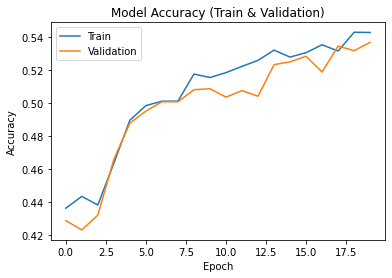

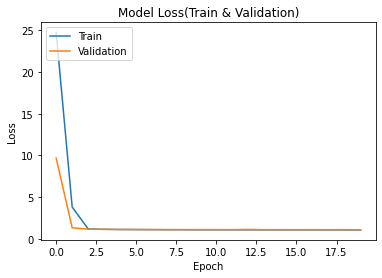

Test data eval
70/70 [==============================] - 1s 16ms/step - loss: 1.1012 - accuracy: 0.5409


In [123]:
model_lstm,lstm_pred_labels = train_evaluate_model(data=data_clean , labels=target_labels,model_type='lstm',
                                  input_length=50, epochs=50, weights=word_embedding_matrix, learning_rate=0.001,
                                  model_units=200,train_on_all_data=False)

In [152]:
# l=np.argmax(lstm_pred_labels,axis=1)
# l = np.where(l==0,-1,l)
# l = np.where(l==1,0,l)
# l = np.where(l==2,1,l)

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 50, 200)           2782800   
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 100)               30100     
_________________________________________________________________
dropout_14 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 3)                 303       
Total params: 2,813,203
Trainable params: 30,403
Non-trainable params: 2,782,800
_________________________________________________________________
None
Epoch 1/20
56/56 [==============================] - 3s 46ms/step - loss: 11.3595 - accuracy: 0.4148 - val_loss: 6.7994 - val_accuracy: 0.4649
Epoch 2/20
56/56 [==============================] - 2s 42ms/step - loss: 4.1086 - accurac

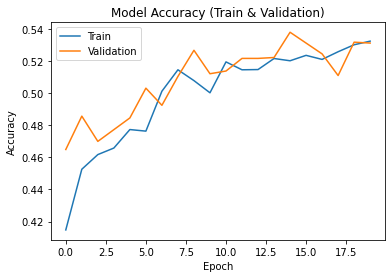

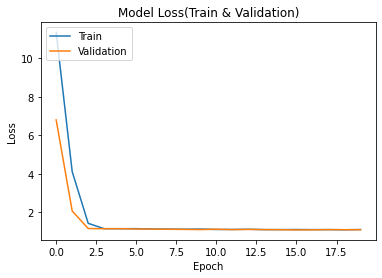

Test data eval
70/70 [==============================] - 0s 7ms/step - loss: 1.0846 - accuracy: 0.5270


In [154]:
model_rnn,rnn_pred_labels = train_evaluate_model(data=data_clean , labels=target_labels,model_type='rnn',
                                  input_length=50, epochs=50, weights=word_embedding_matrix, learning_rate=0.001,
                                  model_units=200,train_on_all_data=False)

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 50, 200)           2782800   
_________________________________________________________________
gru (GRU)                    (None, 100)               90600     
_________________________________________________________________
dropout_15 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 3)                 303       
Total params: 2,873,703
Trainable params: 90,903
Non-trainable params: 2,782,800
_________________________________________________________________
None
Epoch 1/20
56/56 [==============================] - 7s 119ms/step - loss: 21.6868 - accuracy: 0.4332 - val_loss: 9.7207 - val_accuracy: 0.4480
Epoch 2/20
56/56 [==============================] - 5s 97ms/step - loss: 4.2836 - accura

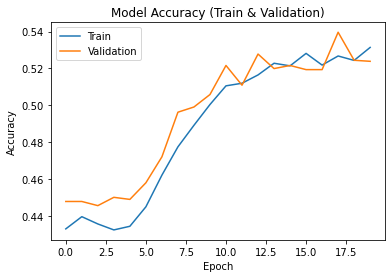

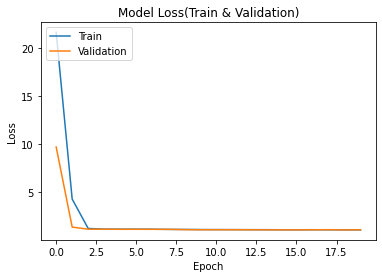

Test data eval
70/70 [==============================] - 1s 12ms/step - loss: 1.0890 - accuracy: 0.5238


In [155]:
model_gru,gru_pred_labels = train_evaluate_model(data=data_clean , labels=target_labels,model_type='gru',
                                  input_length=50, epochs=50, weights=word_embedding_matrix, learning_rate=0.001,
                                  model_units=200,train_on_all_data=False)

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 50, 200)           2782800   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 400)               641600    
_________________________________________________________________
dropout_18 (Dropout)         (None, 400)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 3)                 1203      
Total params: 3,425,603
Trainable params: 642,803
Non-trainable params: 2,782,800
_________________________________________________________________
None
Epoch 1/50
56/56 [==============================] - 22s 387ms/step - loss: 61.8999 - accuracy: 0.4558 - val_loss: 13.2145 - val_accuracy: 0.4199
Epoch 2/50
56/56 [==============================] - 19s 339ms/step - loss: 3.9854 - a

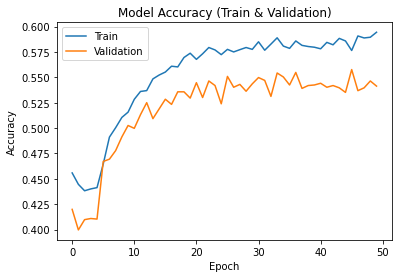

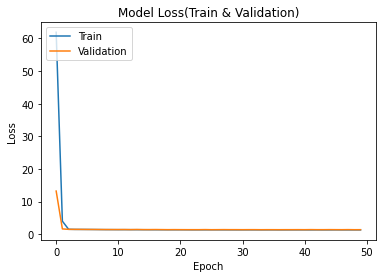

Test data eval
70/70 [==============================] - 3s 47ms/step - loss: 1.3428 - accuracy: 0.5751


In [158]:
model_bilstm,bilstm_pred_labels = train_evaluate_model(data=data_clean , labels=target_labels,model_type='bilstm',
                                  input_length=50, epochs=50, weights=word_embedding_matrix, learning_rate=0.001,
                                  model_units=200,train_on_all_data=False)